In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MPA Optimizasyonu:   0%|          | 0/10 [00:00<?, ?it/s]

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


MPA Optimizasyonu: 100%|██████████| 10/10 [26:49<00:00, 160.91s/it]


En iyi hiperparametreler: [2.56000000e+02 7.26069048e-03]
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - accuracy: 0.4555 - loss: 8.3695 - val_accuracy: 0.0000e+00 - val_loss: 2.6601
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.6213 - loss: 0.8482 - val_accuracy: 0.0450 - val_loss: 2.8244
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7190 - loss: 0.6814 - val_accuracy: 0.0250 - val_loss: 2.3883
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7483 - loss: 0.5801 - val_accuracy: 0.0600 - val_loss: 3.2839
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7872 - loss: 0.5406 - val_accuracy: 0.1000 - val_loss: 2.9865
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7743 - loss: 0.5013 - val_accuracy: 0.1800 - val_loss: 2.6980
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7945 - loss: 0.4788 - val_accuracy: 0.1550 - val_loss: 4.1261
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/s

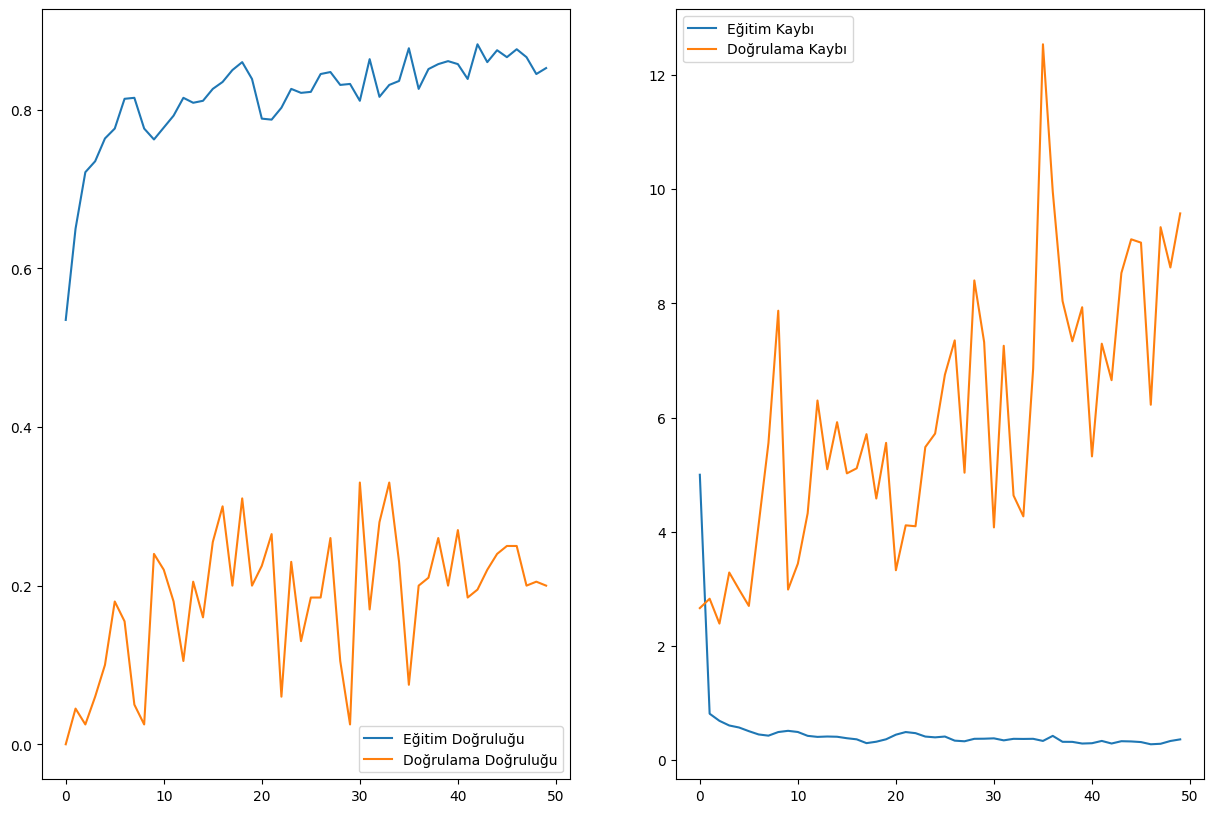

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 209ms/step


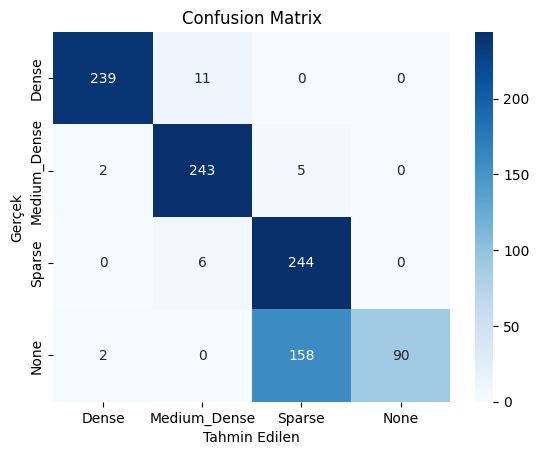

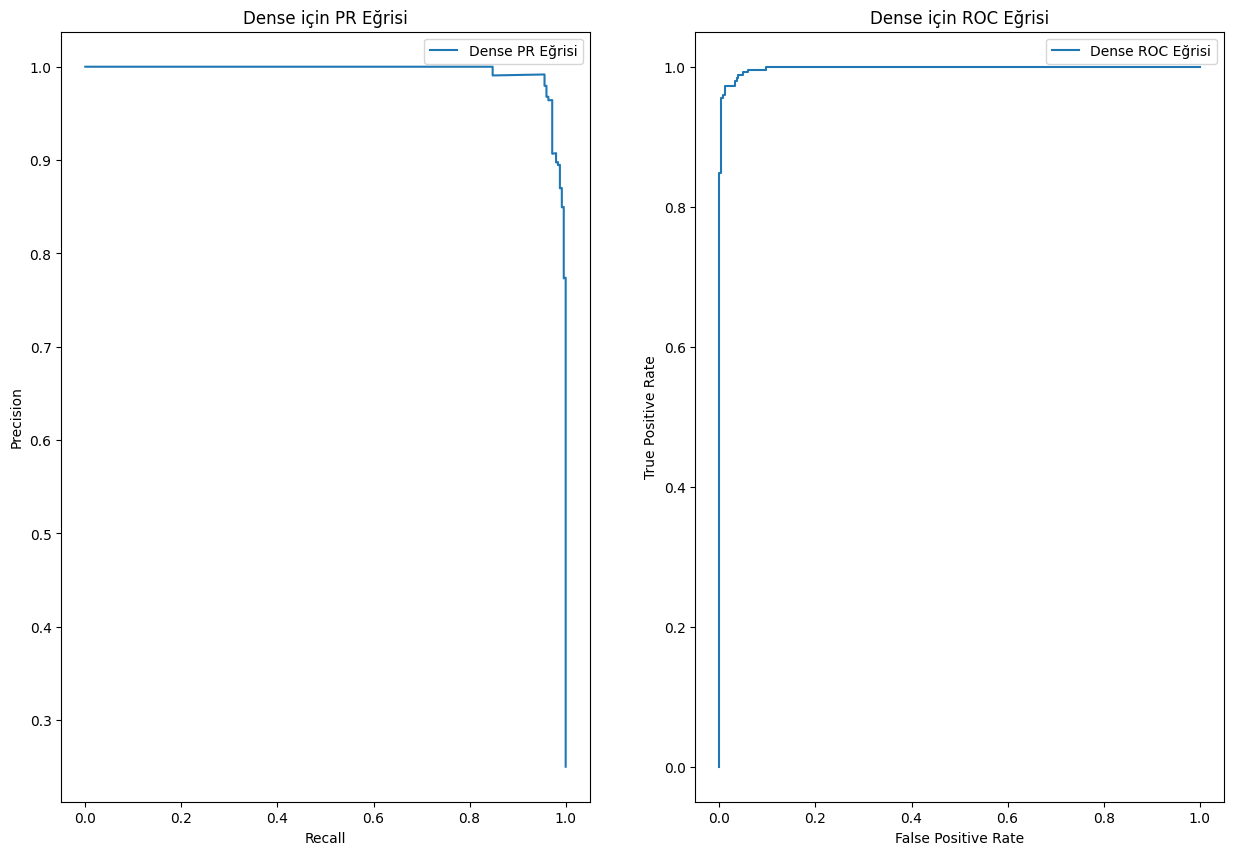

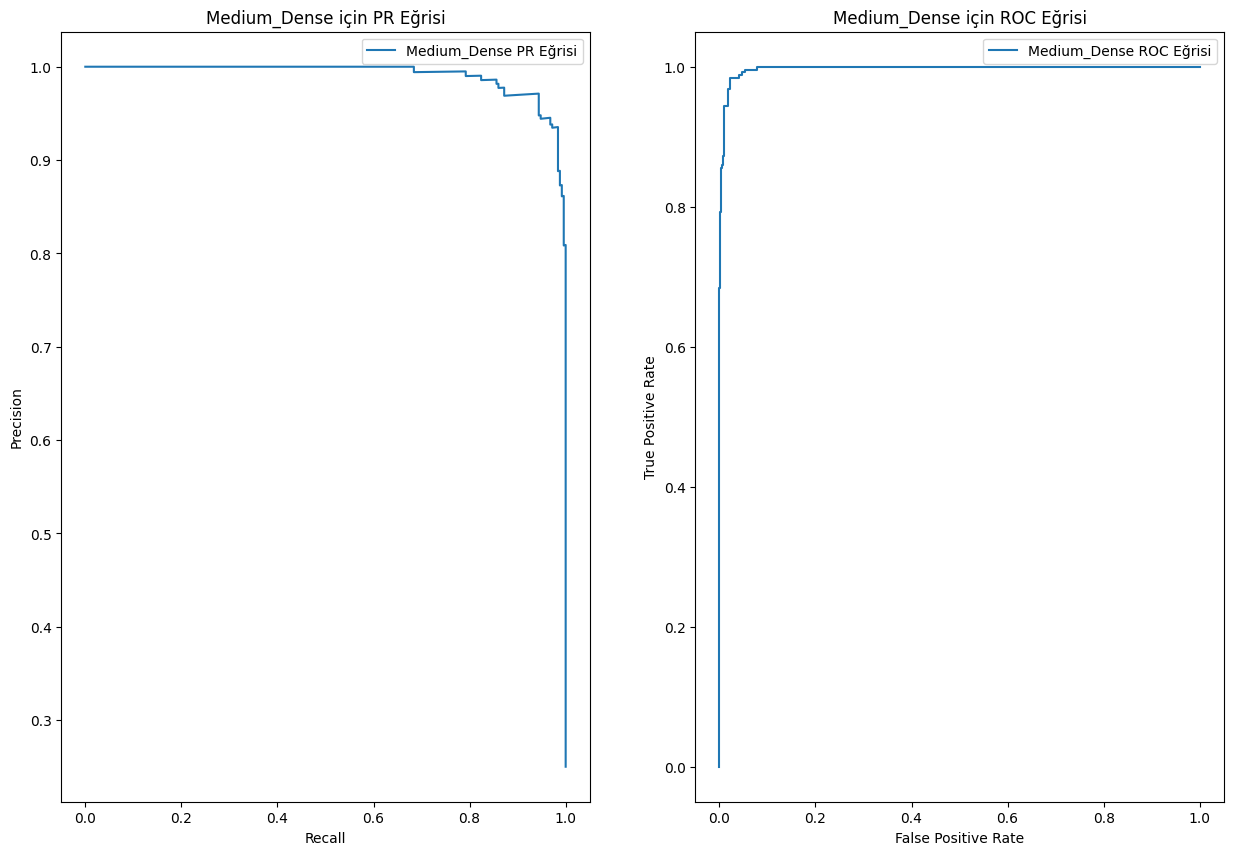

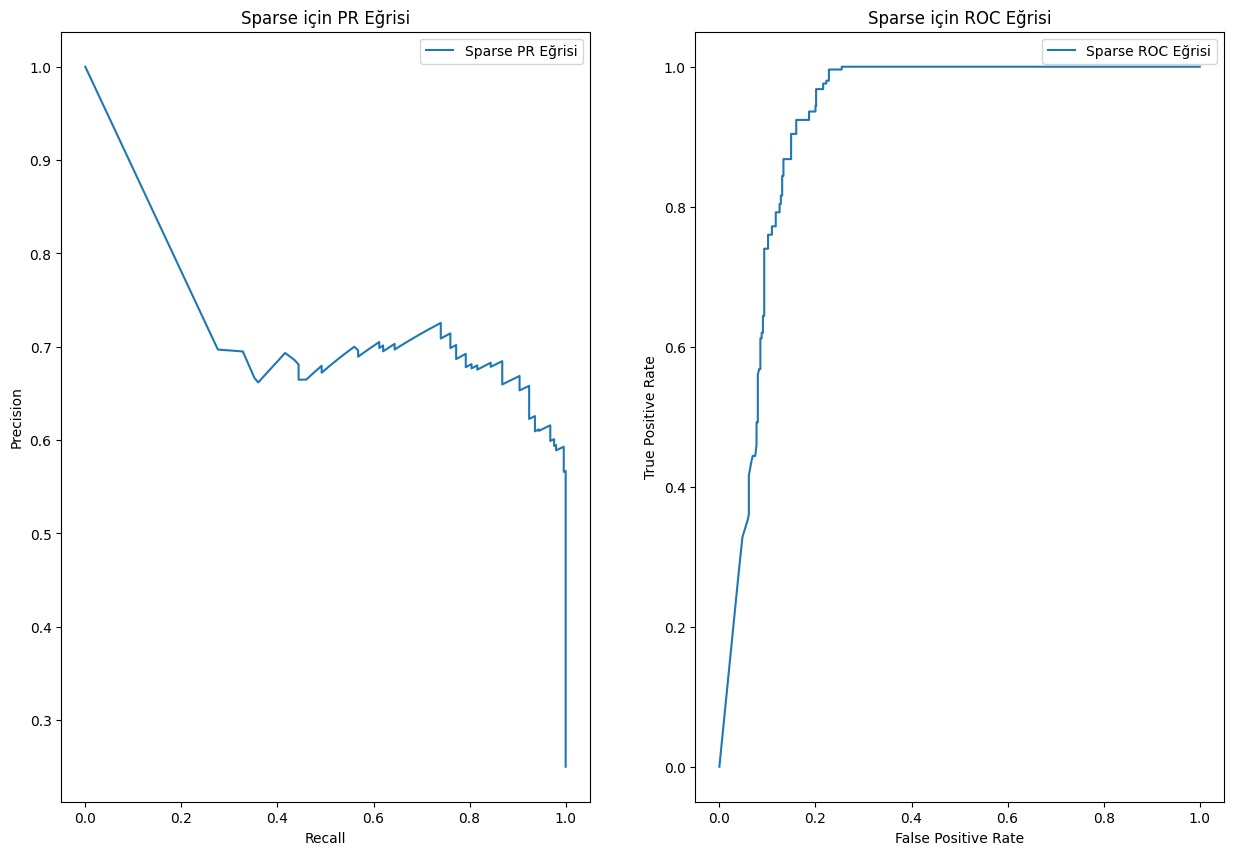

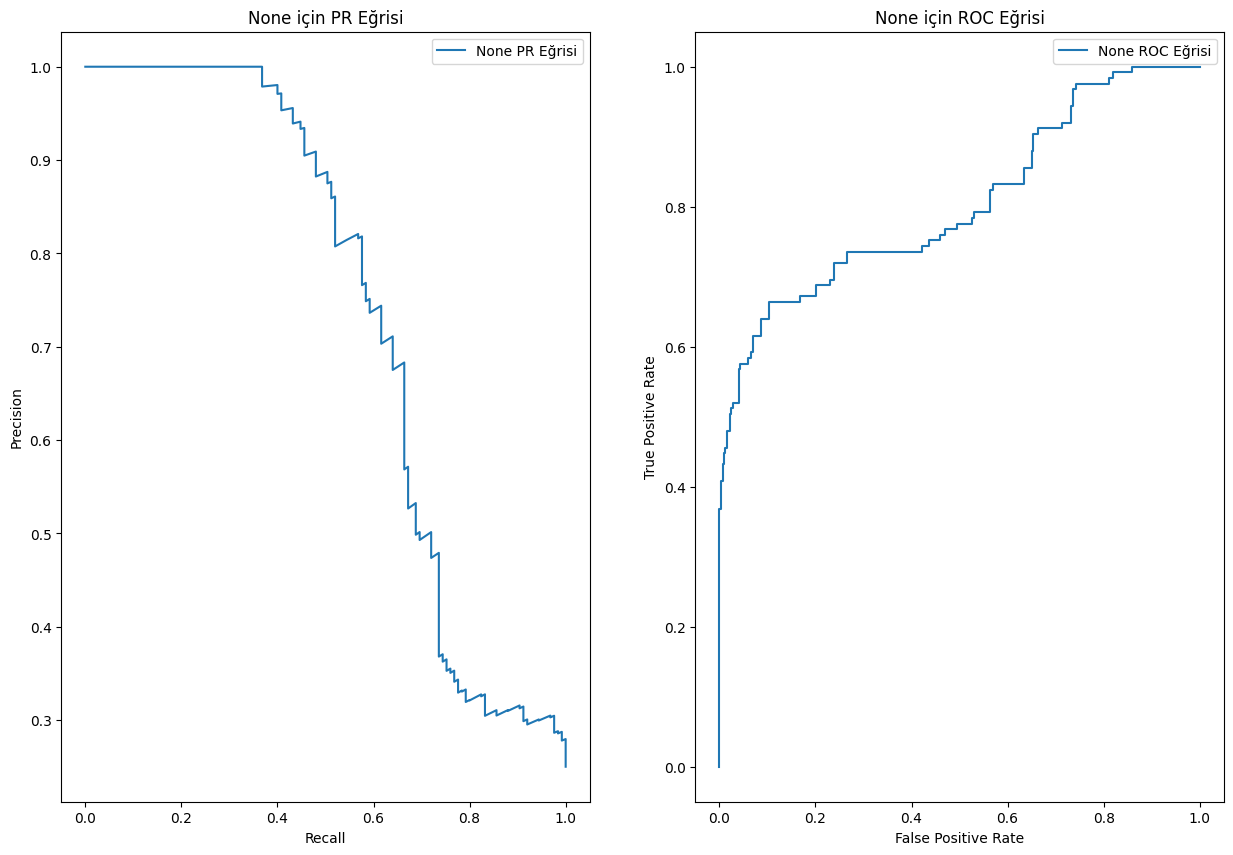

In [ ]:
# Gerekli kütüphanelerin yüklenmesi
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GRU, GlobalAveragePooling2D, Reshape, Dropout
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve, roc_curve, auc, f1_score, precision_score, recall_score
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# 1. CLAHE ile Görselleri İşleme
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Hata: {image_path} yüklenemedi.")
        return None
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(10, 10))
    image = clahe.apply(image)
    image = np.stack([image, image, image], axis=-1) / 255.0
    return image

# 2. Veri Yükleme ve Etiketleme
def load_data(base_dir):
    classes = ['Dense', 'Medium_Dense', 'Sparse', 'None']
    images, labels = [], []
    for cls_index, cls in enumerate(classes):
        cls_dir = os.path.join(base_dir, cls)
        for img_file in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_file)
            processed_img = preprocess_image(img_path)
            if processed_img is not None:
                images.append(processed_img)
                labels.append(cls_index)  # Sınıfları numerik olarak temsil et
    return np.array(images), np.array(labels), classes

# 3. Modeli Oluşturma
def build_model(input_shape, gru_units):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Reshape((1, 2048)),
        GRU(gru_units, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model

# 4. Uygunluk Fonksiyonu
def fitness_function(params):
    """
    Verilen bir hiperparametre setinin uygunluğunu değerlendirir.
    """
    gru_units = int(params[0])
    learning_rate = params[1]

    # Verilen hiperparametrelerle modeli oluştur
    model = build_model((224, 224, 3), gru_units=gru_units)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Modeli sınırlı sayıda epoch için eğit
    history = model.fit(data, labels, validation_split=0.2, epochs=5, batch_size=32, verbose=0)  # Hız için epoch sayısı azaltıldı
    val_loss = history.history['val_loss'][-1]  # Son doğrulama kaybını döndür

    return val_loss

# 5. MPA ile Hiperparametre Optimizasyonu
def marine_predators_algorithm(search_space, max_iter, population_size):
    np.random.seed(42)
    dim = len(search_space)
    X = np.random.uniform(0, 1, (population_size, dim))
    X = X * (np.array([s[1] for s in search_space]) - np.array([s[0] for s in search_space])) + np.array([s[0] for s in search_space])
    fitness = np.full(population_size, float('inf'))

    for iteration in tqdm(range(max_iter), desc="MPA Optimizasyonu"):
        for i in range(population_size):
            candidate = X[i]
            candidate_fitness = fitness_function(candidate)
            if candidate_fitness < fitness[i]:
                fitness[i] = candidate_fitness

        elite = X[np.argmin(fitness)]
        for i in range(population_size):
            if np.random.rand() < 0.5:
                X[i] += np.random.randn(dim) * (elite - X[i])
            else:
                X[i] -= np.random.randn(dim) * (elite - X[i])

            # Değerlerin arama alanı içinde kalmasını sağlamak için kırpın
            X[i] = np.clip(X[i], [s[0] for s in search_space], [s[1] for s in search_space])

    best_idx = np.argmin(fitness)
    return X[best_idx]

# 6. Performans Grafikleri
def plot_metrics(history):
    epochs = range(len(history.history['accuracy']))
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label="Eğitim Doğruluğu")
    plt.plot(epochs, history.history['val_accuracy'], label="Doğrulama Doğruluğu")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label="Eğitim Kaybı")
    plt.plot(epochs, history.history['val_loss'], label="Doğrulama Kaybı")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Tahmin Edilen")
    plt.ylabel("Gerçek")
    plt.title("Confusion Matrix")
    plt.show()

# Epoch başına PR ve ROC Eğrileri
def plot_epoch_pr_roc(y_true, y_probs, classes):
    for i, cls in enumerate(classes):
        plt.figure(figsize=(15, 10))
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, label=f'{cls} PR Eğrisi')
        plt.title(f'{cls} için PR Eğrisi')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, label=f'{cls} ROC Eğrisi')
        plt.title(f'{cls} için ROC Eğrisi')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

# Karşılaştırmalı Tablolar
def create_comparative_table(metrics, methods, title):
    df = pd.DataFrame(metrics, index=methods)
    print(f"{title}:\n{df}")
    df.plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Yöntemler")
    plt.ylabel("Değerler")
    plt.grid(True)
    plt.legend()
    plt.show()

# Ana Program
if __name__ == '__main__':
    base_dir = '/content/drive/MyDrive/Colab Notebooks/dataset2/'  # Kendi veri seti yolunuzu belirtin
    data, labels, classes = load_data(base_dir)

    # Hiperparametre optimizasyonu
    search_space = [(32, 256), (0.0001, 0.01)]  # GRU birimleri ve öğrenme oranı aralıkları
    best_params = marine_predators_algorithm(search_space, max_iter=10, population_size=5)
    print("En iyi hiperparametreler:", best_params)

    # Model eğitimi
    model = build_model((224, 224, 3), gru_units=int(best_params[0]))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params[1]),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(data, labels, validation_split=0.2, epochs=50, batch_size=32)

    # Performans analizleri
    plot_metrics(history)

    # Tahminler ve confusion matrix
    y_pred_probs = model.predict(data)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    plot_confusion_matrix(labels, y_pred_classes, classes)

    # PR ve ROC eğrileri
    y_true_one_hot = tf.keras.utils.to_categorical(labels, num_classes=4)
    plot_epoch_pr_roc(y_true_one_hot, y_pred_probs, classes)